# Questions



<img src="img/14858512893477_so-logo.png" width="600px">    

<h1 style="font-family:verdana;font-size:300%;text-align:left;">Catégorisez automatiquement des questions</h1>

---
<a id="top"></a>
<h1 style="font-family:verdana;font-size:300%;text-align:left;">Sommaire</h1>

* [1. Process](#1)
* [2. Mise en forme](#1)
    * [2.1 Import](#2.1)
    * [2.2 Bag of words](#2.2)
    * [2.3 TF-IDF](#2.3) 
    * [2.4 Word2vec](#2.4)
    * [2.5 Visualisation](#2.5) 
* [3. Approche non supervisée](#3)
    * [3.1 LDA](#3.1) 
    * [3.2 NMF](#3.2)
* [4. Approche supervisée](#4)
    * [4.1 Doc2vec](#4.1) 
    * 

BERT avec  librairie DistilBert 

Pour résumer, LDA et NMF transforment ta matrice documents / mots (obtenue avec bag of words ou TF-IDF) en 2 matrices documents / sujets et sujets / mots.  
 Ta matrice initiale aura beaucoup de features (tous tes mots de tous tes textes). Ta matrice documents / sujets aura n features, où n est le nombre de topics (sujets) que tu auras déterminé pour ton algo LDA ou NMF.  
  Tu auras donc fait une réduction de dimension. Les algo de réduction de dimension (PCA, TSNE, etc.) sont non supervisés. Il en va de même pour LDA et NMF.  

Ensuite, tu as plusieurs possibilités. Si tu obtiens des topics interprétables en terme de tags, tu peux assigner le ou les topics en fonction des résultats de la matrice documents / sujets (non supervisé pur).  
 Sinon, tu peux intégrer LDA ou NMF dans un flux supervisé pour réduire les dimensions (on va dire semi-supervisé ou supervisé avec réduction de dimension).  
 Et peut-être que tu auras de meilleurs résulta ts sans LDA ou NMF (supervisé pur, sans réduction de dimension).


J'ai pas eu trop trop de succès avec les word_embdeddings de type Word2Vec (je me base sur la métrique "v_measure" pour mesurer la correspondance entre mes 7 clusters et les 7 catégories initiales de mes données), donc je me demandais si ça avait des chances de donner de bons résultats.
J'avais utilisé doc2vec , avec plutôt de bons résultats

tester plusieurs modèles simples (5 ou 7, pas de RF et autres modèles consommateur).
Et ça passais du coup parce que j'utilise que des modèles simples (RF + OVR, c'était même pas la peine d'y penser...).

pour évaluer Jaccard

Une régression logistique en OVR 

In [2]:
%matplotlib inline

# Generic librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
from IPython.core.interactiveshell import InteractiveShell

# ML librairies
from gensim import corpora, models, similarities
from sklearn import metrics, decomposition, multiclass


# API, model management
from flask import Flask
import joblib # to save and load the model

# pd.set_option('display.max_column', 100)

# Activate multi output
InteractiveShell.ast_node_interactivity = "all"

# # For jupyter NB users 
# # set size of window
# display(HTML(data="""
# <style>
#     div#notebook-container    { width: 95%; }
#     div#menubar-container     { width: 65%; }
#     div#maintoolbar-container { width: 99%; }
# </style>
# """))

<a id="1"></a>
# 1. Process

---



Nous somme face à un problème de classification multi label.
Nous cherchons pour chaque question à prédire un ou plusieurs tags.

<img src="img/multi label class.png" width="600px">   

Nous allons tout d'abord 



<a id="2"></a>
# 2 Mise en forme
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

<a id="2.1"></a>
## 2.1 Import

Importons notre dataset et placons le dans un pandas dataframe.  
Nous utiliserons les dates comme index.

In [3]:
file = "data/data_clean.csv"
df_raw = pd.read_csv(file, index_col='CreationDate', parse_dates=True)

In [4]:
df_raw.head()
df_raw.shape
df_raw.info()

,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount,Body_tok,Title_tok,Tags_tok,Text_tok,Text
CreationDate,,,,,,,,,,,,,
2010-09-27 06:56:36,152,66955,i lately had the problem of creating add and e...,good or bad practice for dialogs in wpf with m...,<c#><.net><wpf><mvvm><modal-dialog>,3,12,115,"['lately', 'problem', 'creating', 'add', 'edit...","['good', 'bad', 'practice', 'dialog', 'wpf', '...","['c#', '.net', 'wpf', 'mvvm', 'modal', 'dialog']","['good', 'bad', 'practice', 'dialog', 'wpf', '...",good or bad practice for dialogs in wpf with m...
2008-08-11 08:55:13,147,253229,"in c, are the shift operators (<<,>>) arithmet...","are the shift operators (<<, >>) arithmetic or...",<c><binary><bit-manipulation><bit-shift>,11,1,60,"['c', 'shift', 'operator', 'arithmetic', 'logi...","['shift', 'operator', 'arithmetic', 'logical',...","['c', 'binary', 'bit', 'manipulation', 'bit', ...","['shift', 'operator', 'arithmetic', 'logical',...","are the shift operators (<<, >>) arithmetic or..."
2008-08-11 10:27:22,815,576716,"whenever i design a database, i always wonder ...","database, table and column naming conventions?",<database><database-design><language-agnostic>...,23,4,359,"['whenever', 'design', 'database', 'always', '...","['database', 'table', 'column', 'naming', 'con...","['database', 'database', 'design', 'language',...","['database', 'table', 'column', 'naming', 'con...","database, table and column naming conventions?..."
2008-08-11 11:57:17,110,238131,is this even a valid question? i have a .net w...,how do i enable msdtc on sql server?,<sql-server><msdtc>,6,1,30,"['even', 'valid', 'question', '.net', 'window'...","['enable', 'sql', 'server']","['sql', 'server']","['enable', 'sql', 'server', 'even', 'valid', '...",how do i enable msdtc on sql server? is this e...
2008-08-10 18:41:02,539,197771,"what does the expression ""turing complete"" mea...",what is turing complete?,<theory><turing-machines><turing-complete>,15,1,178,"['expression', 'complete', 'mean', 'give', 'si...",['complete'],"['theory', 'machine', 'complete']","['complete', 'expression', 'complete', 'mean',...",what is turing complete? what does the express...


(28077, 13)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 28077 entries, 2010-09-27 06:56:36 to 2018-04-26 23:29:11
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Score          28077 non-null  int64 
 1   ViewCount      28077 non-null  int64 
 2   Body           28077 non-null  object
 3   Title          28077 non-null  object
 4   Tags           28077 non-null  object
 5   AnswerCount    28077 non-null  int64 
 6   CommentCount   28077 non-null  int64 
 7   FavoriteCount  28077 non-null  int64 
 8   Body_tok       28077 non-null  object
 9   Title_tok      28077 non-null  object
 10  Tags_tok       28077 non-null  object
 11  Text_tok       28077 non-null  object
 12  Text           28077 non-null  object
dtypes: int64(5), object(8)
memory usage: 3.0+ MB


In [35]:
# we only keep the texts and the tags
df = df_raw[["Text_tok", "Tags_tok"]].copy()

In [38]:
import ast

# by default list are put in strings by pands, let's convert it to lists
# ast.literal_eval il more secure than eval
df["Text_tok"] = df["Text_tok"].apply(lambda x: ast.literal_eval(x))
df["Tags_tok"] = df["Tags_tok"].apply(lambda x: ast.literal_eval(x))

In [42]:
# we put the text into string form, usefull for vectorizers
df['Text'] = df['Text_tok'].str.join(' ')
df['Tags'] = df['Tags_tok'].str.join(' ')

<a id="2.2"></a>
## 2.2 Bag of words

Nous allons maintenant extraire l'information du texte pour pouvoir le traiter par des modèles de machine learning.

Une représentation bag-of-words classique sera celle dans laquelle on représente chaque document par un vecteur de la taille du vocabulaire  |V|.  
On utilisera la matrice composée de l’ensemble de ces N documents qui forment le corpus comme entrée de nos algorithmes.

In [7]:
# we create a dictionnary of the uniques words of corpus
# each word will have an unique id
dictionary = corpora.Dictionary(df.Text_tok)
print(dictionary)

Dictionary(5286 unique tokens: ['.net', 'achieved', 'add', 'anything', 'anyways']...)


In [8]:
# bag of word (sparse matrix)
# return a list of tuple
# first entry in each tuple corresponds to the ID of the token in the dictionary
# the second corresponds to the count of this token.
bow_corpus = [dictionary.doc2bow(text) for text in df.Text_tok]

In [9]:
# sample
bow_corpus[10][10]

(208, 1)

<a id="2.3"></a>
## 2.3 TF-IDF

Le modèle tf-idf transforme les vecteurs de la représentation bag of word (BOW) en vecteurs dont les fréquences ont pour poids la rareté relative de chaque mot du corpus.

>La métrique tf-idf (Term-Frequency - Inverse Document Frequency) utilise comme indicateur de similarité l'inverse document frequency.  
>Celui ci est est l'inverse de la proportion de document qui contient le terme, à l'échelle logarithmique.  
>Il est appelé logiquement « inverse document frequency » (idf). 

In [10]:
# train the model
model_tfidf = models.TfidfModel(bow_corpus)

# transformation of the corpus
tfidf_corpus = model_tfidf[bow_corpus]

<a id="2.4"></a>
## 2.4 word2vec

Nous allons étudier un modèle de vectorisation des données : Word2vec
Dans l'architecture word2vec, les 2 algorithmes utilisés sont “continuous bag of words” (cbow) et “skip-gram” (sg).

Nous allons entrainer un modèle puis tester les similarités entre les mots.

In [11]:
model_w2v = models.Word2Vec(sentences=df.Text_tok,
window=5,
min_count=5)

In [12]:
model_w2v.wv.similarity("numpy", "matplotlib")
model_w2v.wv.similarity("python", "sql")

0.7181357

0.102911994

On constate que certains termes sont plus "proches" les uns des autres que d'autres.

In [13]:
model_w2v.wv.most_similar(positive=['python', 'numpy', 'android'])

[('scipy', 0.7395392060279846),
 ('matplotlib', 0.6103174686431885),
 ('matlab', 0.600086510181427),
 ('ipython', 0.5958889126777649),
 ('setuptools', 0.5894201993942261),
 ('sklearn', 0.5802245140075684),
 ('collected', 0.5771905183792114),
 ('pyplot', 0.5748153924942017),
 ('panda', 0.5647151470184326),
 ('opencv', 0.5642576813697815)]

On remarque également que pandas a été lemmatizé en panda.

In [ ]:
model_w2v.predict_output_word(['python', 'numpy', 'matplotlib', 'android'], topn=3)

[('numpy', 0.413738), ('import', 0.1391667), ('matplotlib', 0.13184384)]

La méthode prédict output word nous donne uniquement la distribution de probabilité du mot central compte tenu des mots de contexte.  
Cela est une méthode "brute" de prédiction.

<a id="2.5"></a>
## 2.5 Visualisation

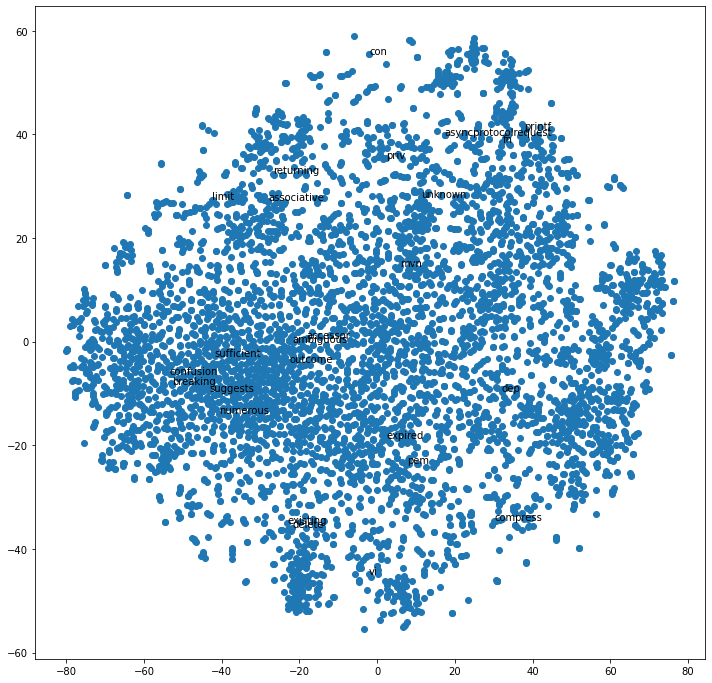

In [19]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction

def reduce_dimensions(model):
    num_dimensions = 2  # final num dimensions (2D, 3D, etc)

    # extract the words & their vectors, as numpy arrays
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)  # fixed-width numpy strings

    # reduce using t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=0)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]
    return x_vals, y_vals, labels


x_vals, y_vals, labels = reduce_dimensions(model_w2v)

def plot_with_matplotlib(x_vals, y_vals, labels):
    import matplotlib.pyplot as plt
    import random

    random.seed(0)

    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals, cmap='Spectral')

    #
    # Label randomly subsampled 25 data points
    #
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 25)
    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

# plot_function(x_vals, y_vals, labels)

plot_with_matplotlib(x_vals, y_vals, labels);

<a id="3"></a>
# 3. Approche non supervisée
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---

<a id="3.1"></a>
## 3.1 LDA

>L’allocation de Dirichlet latente (Latent Dirichlet Allocation) ou LDA est un modèle génératif probabiliste  
>permettant d’expliquer des ensembles d’observations, par le moyen de groupes non observés,  
>eux-mêmes définis par des similarités de données.

Option :
* pyLDAvis

In [44]:
from sklearn.model_selection import train_test_split

X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(
    df['Text'], df['Tags'], test_size=0.2,train_size=0.8, random_state=42)

In [100]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Sampling dataset
vectorizer_tfidf = TfidfVectorizer(analyzer='word', min_df=0.0, max_df = 1.0, 
                                   strip_accents = None, encoding = 'utf-8', 
                                   preprocessor=None, 
                                   token_pattern=r"(?u)\S\S+", # Need to repeat token pattern
                                   max_features=10000)

# TF-IDF matrices
X_tfidf_train = vectorizer_tfidf.fit_transform(X_lda_train)
X_tfidf_test = vectorizer_tfidf.transform(X_lda_test)

L(w) is the log-likelihood of the unseen documents w; the lower the perplexity, the better the model.

Extracting term frequency features for LDA...


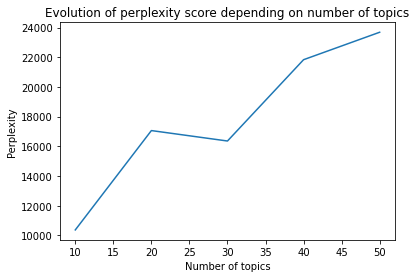

In [55]:
def lda_perplexity(vectorizer, data_train, data_test):

    ''' Showing the perplexity score for several LDA models with different values
    for n_components parameter, and printing the top words for the best LDA model
    (the one with the lowest perplexity)
    Parameters:
    vectorizer: TF-IDF convertizer                                              
    data_train: data to fit the model with
    data_test: data to test
    '''

    best_perplexity = np.inf
    best_lda = 0
    perplexity_list = []
    n_topics_list = []
    print("Extracting term frequency features for LDA...")

    for n_topics in np.linspace(10, 50, 5, dtype='int'):
        lda_model = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                        learning_method='online',
                                        learning_offset=50.,
                                        random_state=0).fit(data_train)
        n_topics_list.append(n_topics)
        perplexity = lda_model.perplexity(data_test)
        perplexity_list.append(perplexity)

        # Perplexity is defined as exp(-1. * log-likelihood per word)
        # Perplexity: The smaller the better
        if perplexity <= best_perplexity:
            best_perplexity = perplexity
            best_lda = lda_model
                                
    plt.title("Evolution of perplexity score depending on number of topics")
    plt.xlabel("Number of topics")
    plt.ylabel("Perplexity")
    plt.plot(n_topics_list, perplexity_list)
    plt.show()

lda_perplexity(vectorizer_tfidf, X_tfidf_train, X_tfidf_test)

The lowest perplexity score is for 10 topics, so we will learn the lda model with 10 topics.

In [118]:
n_topics = 10

lda_model_tfidf = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0).fit(X_tfidf_train)

feature_names = vectorizer_tfidf.get_feature_names()
lda_components = lda_model_tfidf.components_ / lda_model_tfidf.components_.sum(axis=1)[:, np.newaxis] # normalization

Entrainons également un modèle qui se base sur un Countvectorizer.

In [119]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_tf = CountVectorizer(max_features=10000)
X_tf_train = vectorizer_tf.fit_transform(X_lda_train)

n_topics = 10

lda_model_tf = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                    learning_method='online',
                                    learning_offset=50.,
                                    random_state=0).fit(X_tf_train)

In [124]:
def return_tag(text_test, vectorizer, model):

    text_tfidf = vectorizer.transform(text_test)
    text_projection = model.transform(text_tfidf)

    threshold = 0.005 # defined after tests
    list_scores = []
    list_words = []
    used = set()

    lda_components = model.components_ / model.components_.sum(axis=1)[:, np.newaxis] # normalization
    feature_names = vectorizer.get_feature_names()

    for topic in range(n_topics):
        topic_score = text_projection[0][topic]

        for (word_idx, word_score) in zip(lda_components[topic].argsort()[:-5:-1], sorted(lda_components[topic])[:-5:-1]):
            score = topic_score*word_score

            if score >= threshold:
                list_scores.append(score)
                list_words.append(feature_names[word_idx])
                used.add(feature_names[word_idx])

    results = [tag for (y,tag) in sorted(zip(list_scores,list_words), key=lambda pair: pair[0], reverse=True)]
    tags = " ".join(results[:5])

    return tags

In [87]:
# a supprimer
def average_jaccard(y_true,y_pred):

    ''' It calculates Jaccard similarity coefficient score for each instance,and
    it finds their average in percentage
    Parameters:
    y_true: truth labels
    y_pred: predicted labels
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

In [128]:
text_test = [X_lda_test[0]]

return_tag(text_test, vectorizer_tfidf, lda_model_tfidf)
return_tag(text_test, vectorizer_tf, lda_model_tf)
y_lda_test[0]

'string array value list'

'string value return object table'

'php array string'

## fastLDA a essayer

<a id="3.2"></a>
## 3.2 NMF

Negative Matrix Factorisation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# # NMF is able to use tf-idf
# tfidf_vectorizer = TfidfVectorizer(max_df=0.95, 
#     min_df=2, 
#     max_features=no_features, 
#     stop_words='english')
# tfidf = tfidf_vectorizer.fit_transform(documents)
# tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,
    analyzer=lambda x: x, # disable the analyser as we already have tokens
    stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df.Text_tok)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

no_topics = 20

# Run NMF
nmf = NMF(n_components=no_topics,
random_state=1,
alpha=.1,
l1_ratio=.5,
init='nndsvd') # Nonnegative Double Singular Value Decomposition (NNDSVD) initialization (better for sparseness)

nmf.fit(tfidf)

NMF(alpha=0.1, init='nndsvd', l1_ratio=0.5, n_components=20, random_state=1)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10

In [ ]:
display_topics(nmf, tfidf_feature_names, no_top_words)

Topic 0:
use would user error using code get like http application
Topic 1:
file directory folder path txt open filename name read want
Topic 2:
android layout id app activity view studio com parent width
Topic 3:
string character convert str split replace number way char hello
Topic 4:
git branch commit repository remote master push change github origin
Topic 5:
div px cs element text image width height html id
Topic 6:
table column sql mysql database row query data select id
Topic 7:
array element numpy arr var way javascript index php int
Topic 8:
class public method static int void test private foo name
Topic 9:
line command script bash text run window output vim echo
Topic 10:
list item element arraylist way index sort new would like
Topic 11:
function javascript return var jquery call script event alert php
Topic 12:
difference v use two one explain used ruby example understand
Topic 13:
date format time datetime day mm month current convert dd
Topic 14:
python py install package

<a id="4"></a>
# 4. Approche supervisée
<a href="#top" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Sommaire</a>

---



<a id="4.1"></a>
## 4.1 Doc2vec

Les algorithmes utilisés dans l'architecture de doc2vec sont “distributed memory” (dm) et “distributed bag of words” (dbow).

Pour ce plongement de mots il est nécessaire d'associé les tags au corpus.  
Nous abordons donc une approche supervisée.

In [129]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df["Text_tok"], df['Tags_tok'], test_size=0.3, random_state=42)

In [130]:
# we need to put our data in a specific form for doc2vec
train_corpus = [models.doc2vec.TaggedDocument(doc, i) for doc, i in zip(x_train, y_train)]

In [131]:
test_corpus = x_test.to_list()

In [132]:
# instancing the model
model_d2v = models.doc2vec.Doc2Vec(vector_size=50,
min_count=2,
epochs=40)

In [133]:
model_d2v.build_vocab(train_corpus)

In [134]:
# sample
print(f"Word 'android' appeared {model_d2v.wv.get_vecattr('android', 'count')} times in the training corpus.")


Word 'android' appeared 8627 times in the training corpus.


In [135]:
model_d2v.train(train_corpus, total_examples=model_d2v.corpus_count, epochs=model_d2v.epochs)

In [224]:
doc_id = 7
inferred_vector = model_d2v.infer_vector(test_corpus[doc_id])
sims = model_d2v.dv.most_similar([inferred_vector], topn=len(set(y_test[doc_id])))
[w[0] for w in sims]
y_test[doc_id]

y_pred = list(set([w[0] for w in sims]))
y_true = list(set(y_test[doc_id]))
y_pred
y_true
metrics.jaccard_score(y_true, y_pred, average="weighted")

['letter', 'git']

['git', 'merge', 'git', 'merge']

['letter', 'git']

['merge', 'git']

0.5

In [214]:
len(set(y_test[doc_id]))

4

In [254]:
import warnings

# I expect to see RuntimeWarnings in this block
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)

    scores = []

    for i in range(0, len(y_test)-1):
        inferred_vector = model_d2v.infer_vector(test_corpus[i])
        sims = model_d2v.dv.most_similar([inferred_vector], topn=len(set(y_test[i])))
        # [w[0] for w in sims]
        # y_test[i]

        y_pred = sorted(set([w[0] for w in sims]))    
        y_true = sorted(set(y_test[i]))
        
        scores.append(metrics.jaccard_score(y_true, y_pred, average="weighted"))

In [255]:
from statistics import mean

mean([s for s in scores if str(s) != 'nan'])

0.11719349718992193

## Vidéo indien

In [256]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.multiclass import OneVsRestClassifier

In [261]:
y = df['Tags_tok']
y

CreationDate
2010-09-27 06:56:36                 [c#, .net, wpf, mvvm, modal, dialog]
2008-08-11 08:55:13           [c, binary, bit, manipulation, bit, shift]
2008-08-11 10:27:22    [database, database, design, language, naming,...
2008-08-11 11:57:17                                        [sql, server]
2008-08-10 18:41:02                          [theory, machine, complete]
                                             ...                        
2017-01-29 10:58:46             [python, multiprocessing, progress, bar]
2017-01-30 03:16:39                                            [reactjs]
2017-01-30 03:56:48                                 [java, json, kotlin]
2017-01-30 14:47:03                                              [axios]
2018-04-26 23:29:11                       [virtual, machine, virtualbox]
Name: Tags_tok, Length: 28077, dtype: object

In [262]:
multilabel = MultiLabelBinarizer()
y = multilabel.fit_transform(y)
y

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [263]:
pd.DataFrame(y, columns=multilabel.classes_)

,.net,4net,aapt,aar,abort,absolute,abstract,abstraction,access,accessor,...,year,yield,youtube,yum,zend,zero,zip,zoom,zsh,zurb
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28072,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28073,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28074,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28075,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Metrics for Multi-label classification


**Multi-label classification** problems must be assessed using different performance measures than single-label classification problems. Two of the most common performance metrics are hamming loss and Jaccard similarity.

**Hamming loss** is the average fraction of incorrect labels. Note that hamming loss is a loss function and that the perfect score is 0.

where TP + TN + FP + FN =L(the total number of labels).

**Jaccard similarity** or the Jaccard index, is the size of the intersection of the predicted labels and the true labels divided by the size of the union of the predicted and true labels. It ranges from 0 to 1, and 1 is the perfect score.


In [264]:
tfidf = TfidfVectorizer(
    analyzer='word',
    max_features=10000)


In [265]:
X = tfidf.fit_transform(df['Text'])
X.shape, y.shape

((28077, 5261), (28077, 2834))

In [266]:
X = tfidf_corpus

In [268]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [279]:
X_train

[[(18, 0.09927353283786651),
  (58, 0.07374165302912239),
  (75, 0.08634299825896588),
  (86, 0.4081681641559019),
  (92, 0.09096816859658043),
  (95, 0.09208441718512064),
  (100, 0.1087008440706187),
  (103, 0.0592495842460223),
  (121, 0.11442249605325785),
  (136, 0.11189686029235767),
  (181, 0.12381087687780147),
  (182, 0.1184912979170802),
  (184, 0.100141219827389),
  (214, 0.11343034742662148),
  (281, 0.1278217736142305),
  (294, 0.23403352513248432),
  (410, 0.05585027441418481),
  (472, 0.14810981010848523),
  (884, 0.12317999357804722),
  (1004, 0.46660271280834426),
  (1123, 0.22481856234860909),
  (1347, 0.17799167919128103),
  (2339, 0.21650264385298565),
  (2625, 0.23183586933227324),
  (2818, 0.25801515826480986),
  (3073, 0.23380209134638924),
  (4477, 0.2599111310200692)],
 [(58, 0.15788660219958559),
  (97, 0.12372898623822667),
  (131, 0.36255435070586317),
  (136, 0.11978993108131804),
  (172, 0.22753876037941134),
  (184, 0.42882024715187994),
  (695, 0.4121413

In [269]:
sgd = SGDClassifier()
lr = LogisticRegression(solver='lbfgs')
svc = LinearSVC()

In [270]:
def j_score(y_true, y_pred):
  jaccard = np.minimum(y_true, y_pred).sum(axis = 1)/np.maximum(y_true, y_pred).sum(axis = 1)
  return jaccard.mean()*100


def print_score(y_pred, clf):
  print("Clf: ", clf.__class__.__name__)
  print('Jacard score: {}'.format(j_score(y_test, y_pred)))
  print('----')

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

Q = {'What does the "yield" keyword do in Python?': ['python'],
     'What is a metaclass in Python?': ['oop'],
     'How do I check whether a file exists using Python?': ['python'],
     'How to make a chain of function decorators?': ['python', 'decorator'],
     'Using i and j as variables in Matlab': ['matlab', 'naming-conventions'],
     'MATLAB: get variable type': ['matlab'],
     'Why is MATLAB so fast in matrix multiplication?': ['performance'],
     'Is MATLAB OOP slow or am I doing something wrong?': ['matlab-oop'],
    }
dataframe = pd.DataFrame({'body': Q.keys(), 'tag': Q.values()})    

mlb = MultiLabelBinarizer()
X = dataframe['body'].values 
y = mlb.fit_transform(dataframe['tag'].values)

classifier = Pipeline([
    ('vectorizer', CountVectorizer(lowercase=True, 
                                   stop_words='english', 
                                   max_df=0.8, 
                                   min_df=1)),
    ('tfidf', TfidfTransformer()),
    ('clf', OneVsRestClassifier(LinearSVC()))])

In [ ]:
import numpy as np
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
X = np.array([
    [10, 10],
    [8, 10],
    [-5, 5.5],
    [-5.4, 5.5],
    [-20, -20],
    [-15, -20]
])
y = np.array([0, 0, 1, 1, 2, 2])
clf = OneVsRestClassifier(SVC()).fit(X, y)
clf.predict([[-19, -20], [9, 9], [-5, 5]])


array([2, 0, 1])

In [272]:
for classifier in [LinearSVC(C=1.5, penalty = 'l1', dual=False)]:
  clf = OneVsRestClassifier(classifier)
  clf.fit(X_train, y_train)
  # y_pred = clf.predict(X_test)
  # print_score(y_pred, classifier)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (21057,) + inhomogeneous part.

In [ ]:
# for classifier in [sgd, lr, svc]:
#   clf = OneVsRestClassifier(classifier)
#   clf.fit(X_train, y_train) 
#   y_pred = clf.predict(X_test)
#   print_score(y_pred, classifier)

clf = OneVsRestClassifier(lr)
clf.fit(X_train, y_train) 
y_pred = clf.predict(X_test)
print_score(y_pred, lr)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (21057,) + inhomogeneous part.

In [ ]:
x = [ 'how to write ml code in python and java i have data but do not know how to do it']

In [ ]:
xt = tfidf.transform(x)
clf.predict(xt)

AttributeError: 'OneVsRestClassifier' object has no attribute 'estimators_'

In [ ]:
multilabel.inverse_transform(clf.predict(xt))


[()]

# Save model and flask

In [ ]:
# joblib.dump(my_model, "my_model.pkl")
# # and later...
# my_model_loaded = joblib.load("my_model.pkl")

In [ ]:
from flask import Flask
from app.src.main import Predict

app = Flask(_name_)


@app.route('/')
def hello():
    return 'Hello, World!'


@app.route('/predict/<path:path_X_test>')
def predict(path_X_test):
    """
    Example: 
    path_X_test=app/data/dataset_single.csv
    Link: 
        http://127.0.0.1:5000/predict/app/data/dataset_single.csv
    """
    isinstance(path_X_test, str)
    y_pred = Predict(path_X_test)
    return {'status': 'OK', 'y_pred': y_pred.tolist()}


if _name_ == '_main_':
    app.run('0.0.0.0', 5000)


postman pour tester les API


SyntaxError: invalid syntax (<ipython-input-66-3f4c96392582>, line 29)